In [199]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats


In [273]:
kfolds = 10
lambs = ['1', '10', '100', '1000', '10000', '100000']
cutoff = 10**-11

1


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


10
100
1000
10000
100000


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10


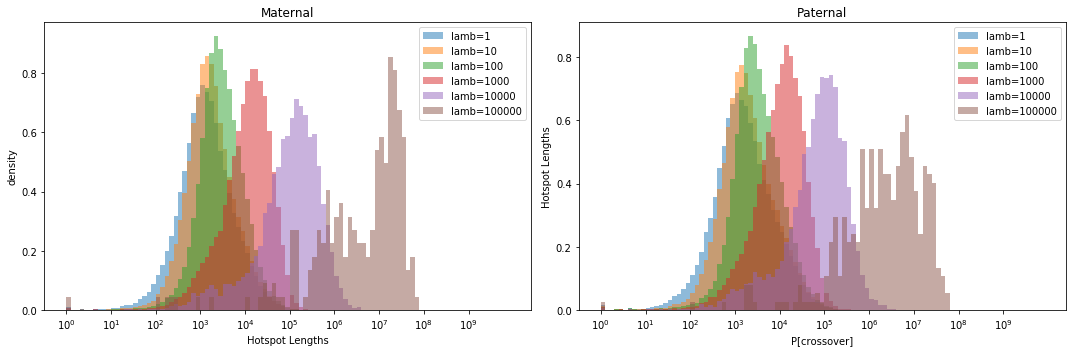

In [225]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for lamb in lambs:
    print(lamb)
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_mat = (ps_mat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1, np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
    if is_hotspot_mat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_mat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_mat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 9), alpha=0.5, bins=np.arange(0, 10, 0.1), density=True, label='lamb=%s' % lamb)

plt.title('Maternal')
plt.xlabel('Hotspot Lengths')
plt.ylabel('density')
plt.xticks(np.arange(0, 10), ['$10^{%d}$' % x for x in np.arange(0, 10)])
plt.legend()

plt.subplot(1, 2, 2)
for lamb in lambs:   
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_pat = (ps_pat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1, np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
    if is_hotspot_pat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_pat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_pat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 9), alpha=0.5, bins=np.arange(0, 10, 0.1), density=True, label='lamb=%s' % lamb)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(0, 10), ['$10^{%d}$' % x for x in np.arange(0, 10)])
plt.ylabel('Hotspot Lengths')
plt.legend()  

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


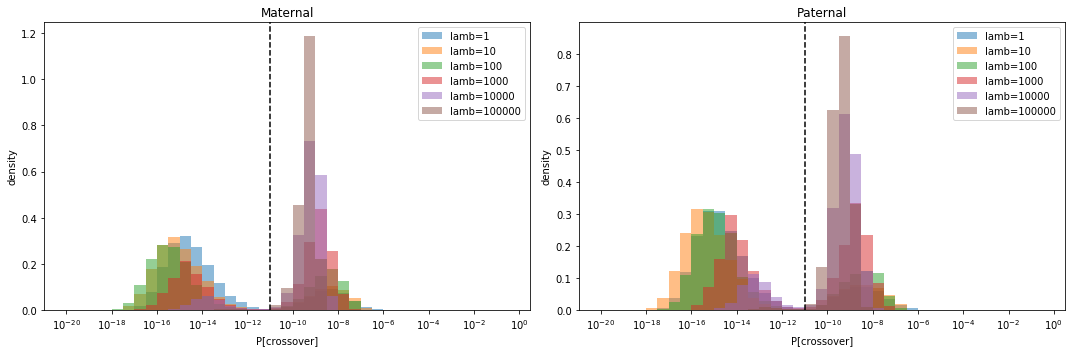

In [226]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for lamb in lambs:
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='lamb=%s' % lamb)

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
for lamb in lambs:   
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='lamb=%s' % lamb)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


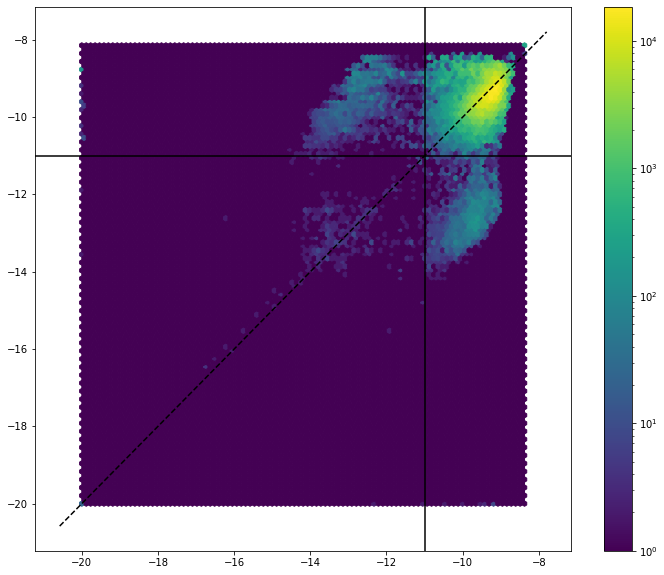

In [228]:
lamb = 100000
k = 0

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))

plt.figure(figsize=(12, 10))
plt.hexbin(np.clip(np.log10(ps_mat[lengths!=0]) - np.log10(lengths[lengths!=0]), -20, 0), 
            np.clip(np.log10(ps_pat[lengths!=0]) - np.log10(lengths[lengths!=0]), -20, 0),
          gridsize=100, bins='log')#, marker='.', alpha=0.1)
plt.colorbar()
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(np.log10(cutoff), color='black')
plt.axvline(np.log10(cutoff), color='black')
plt.show()

In [318]:
def pull_data(recomb_file):
    genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_train, co_in_hotspot_pat_train = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_test, co_in_hotspot_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    
    lengths = np.load('%s.lengths.npy' % recomb_file)

    for i, lamb in enumerate(lambs):
        for k in range(kfolds):
            try:
                ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
                is_mat_hotspot = (ps_mat/lengths > cutoff)

                co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_mat_train = np.clip(co_ps_mat_train, co_lengths_mat_train*10**-12, None)
                co_ps_mat_test = np.clip(co_ps_mat_test, co_lengths_mat_test*10**-12, None)
                genome_in_hotspot_mat[i, k] = is_mat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_mat_train[i, k] = np.sum(np.log(co_ps_mat_train))/len(co_ps_mat_train)
                co_in_hotspot_mat_test[i, k] = np.sum(np.log(co_ps_mat_test))/len(co_ps_mat_test)

                ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
                is_pat_hotspot = (ps_pat/lengths > cutoff)

                co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_pat_train = np.clip(co_ps_pat_train, co_lengths_pat_train*10**-12, None)
                co_ps_pat_test = np.clip(co_ps_pat_test, co_lengths_pat_test*10**-12, None)
                genome_in_hotspot_pat[i, k] = is_pat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_pat_train[i, k] = np.sum(np.log(co_ps_pat_train))/len(co_ps_pat_train)
                co_in_hotspot_pat_test[i, k] = np.sum(np.log(co_ps_pat_test))/len(co_ps_pat_test)
                genome_in_hotspot[i, k] = (is_mat_hotspot & is_pat_hotspot).dot(lengths)/np.sum(lengths)
            except Exception as e:
                print(e)
    return genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot, co_in_hotspot_mat_train, co_in_hotspot_pat_train, co_in_hotspot_mat_test, co_in_hotspot_pat_test

wgs_genome_in_hotspot_mat, wgs_genome_in_hotspot_pat, wgs_genome_in_hotspot, \
wgs_co_in_hotspot_mat_train, wgs_co_in_hotspot_pat_train, \
wgs_co_in_hotspot_mat_test, wgs_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs')

chip_genome_in_hotspot_mat, chip_genome_in_hotspot_pat, chip_genome_in_hotspot, \
chip_co_in_hotspot_mat_train, chip_co_in_hotspot_pat_train, \
chip_co_in_hotspot_mat_test, chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip')

wgs_chip_genome_in_hotspot_mat, wgs_chip_genome_in_hotspot_pat, wgs_chip_genome_in_hotspot, \
wgs_chip_co_in_hotspot_mat_train, wgs_chip_co_in_hotspot_pat_train, \
wgs_chip_co_in_hotspot_mat_test, wgs_chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip')

wgs_linked_genome_in_hotspot_mat, wgs_linked_genome_in_hotspot_pat, wgs_linked_genome_in_hotspot, \
wgs_linked_co_in_hotspot_mat_train, wgs_linked_co_in_hotspot_pat_train, \
wgs_linked_co_in_hotspot_mat_test, wgs_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_linked')

chip_linked_genome_in_hotspot_mat, chip_linked_genome_in_hotspot_pat, chip_linked_genome_in_hotspot, \
chip_linked_co_in_hotspot_mat_train, chip_linked_co_in_hotspot_pat_train, \
chip_linked_co_in_hotspot_mat_test, chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip_linked')

wgs_chip_linked_genome_in_hotspot_mat, wgs_chip_linked_genome_in_hotspot_pat, wgs_chip_linked_genome_in_hotspot, \
wgs_chip_linked_co_in_hotspot_mat_train, wgs_chip_linked_co_in_hotspot_pat_train, \
wgs_chip_linked_co_in_hotspot_mat_test, wgs_chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip_linked')


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


[Errno 2] No such file or directory: '../recombination_rate/wgs.crossover_lengths_pat_train.1.1.npy'
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
[Errno 2] No such file or directory: '../recombination_rate/wgs.crossover_lengths_pat_train.10.1.npy'
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591701,) (591700,) 
operands could not be broadcast together with shapes (591

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.10.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.10.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.10.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.10.9.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.1.6.npy'
[Errno 2] No such file or directory: '../recomb

[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/chip_linked.ps_mat.100000.9.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip_linked.ps_mat.1.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip_linked.ps_mat.1.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip_lin

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


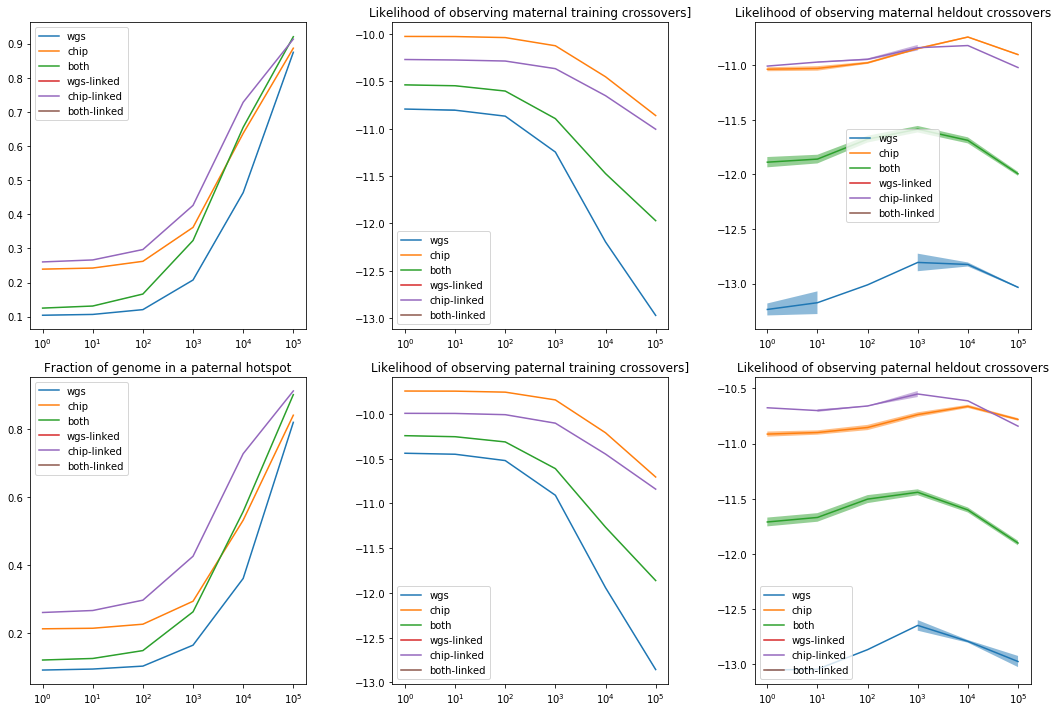

In [319]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(np.nanmean(data, axis=1), label=label)
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(np.arange(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plot_with_confidence(wgs_genome_in_hotspot_mat, 'wgs')
plot_with_confidence(chip_genome_in_hotspot_mat, 'chip')
plot_with_confidence(wgs_chip_genome_in_hotspot_mat, 'both')
plot_with_confidence(wgs_linked_genome_in_hotspot_mat, 'wgs-linked')
plot_with_confidence(chip_linked_genome_in_hotspot_mat, 'chip-linked')
plot_with_confidence(wgs_chip_linked_genome_in_hotspot_mat, 'both-linked')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 4)
plot_with_confidence(wgs_genome_in_hotspot_pat, 'wgs')
plot_with_confidence(chip_genome_in_hotspot_pat, 'chip')
plot_with_confidence(wgs_chip_genome_in_hotspot_pat, 'both')
plot_with_confidence(wgs_linked_genome_in_hotspot_pat, 'wgs-linked')
plot_with_confidence(chip_linked_genome_in_hotspot_pat, 'chip-linked')
plot_with_confidence(wgs_chip_linked_genome_in_hotspot_pat, 'both-linked')
plt.title('Fraction of genome in a paternal hotspot')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 2)
plot_with_confidence(wgs_co_in_hotspot_mat_train, 'wgs')
plot_with_confidence(chip_co_in_hotspot_mat_train, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_mat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_train, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_mat_train, 'chip-linked')
plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_train, 'both-linked')
plt.title('Likelihood of observing maternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 5)
plot_with_confidence(wgs_co_in_hotspot_pat_train, 'wgs')
plot_with_confidence(chip_co_in_hotspot_pat_train, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_pat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_train, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_pat_train, 'chip-linked')
plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_train, 'both-linked')
plt.title('Likelihood of observing paternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 3)
plot_with_confidence(wgs_co_in_hotspot_mat_test, 'wgs')
plot_with_confidence(chip_co_in_hotspot_mat_test, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_mat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_test, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_mat_test, 'chip-linked')
plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_test, 'both-linked')
plt.title('Likelihood of observing maternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 6)
plot_with_confidence(wgs_co_in_hotspot_pat_test, 'wgs')
plot_with_confidence(chip_co_in_hotspot_pat_test, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_pat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_test, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_pat_test, 'chip-linked')
plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_test, 'both-linked')
plt.title('Likelihood of observing paternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.tight_layout()
plt.show()

In [305]:
lamb_wgs_mat = lambs[np.argmax(np.nanmean(wgs_co_in_hotspot_mat_test, axis=1))]
lamb_wgs_pat = lambs[np.argmax(np.nanmean(wgs_co_in_hotspot_pat_test, axis=1))]
lamb_chip_mat = lambs[np.argmax(np.nanmean(chip_co_in_hotspot_mat_test, axis=1))]
lamb_chip_pat = lambs[np.argmax(np.nanmean(chip_co_in_hotspot_pat_test, axis=1))]
lamb_wgschip_mat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_mat_test, axis=1))]
lamb_wgschip_pat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_pat_test, axis=1))]

print(lamb_wgs_mat, lamb_wgs_pat)
print(lamb_chip_mat, lamb_chip_pat)
print(lamb_wgschip_mat, lamb_wgschip_pat)

1 1
10000 10000
1000 1000


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


# Look at best performers

269550 (269549,) (269549,) (269549,)
[('1', 1), ('1', 858952), ('1', 903175), ('1', 905373), ('1', 911428)]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


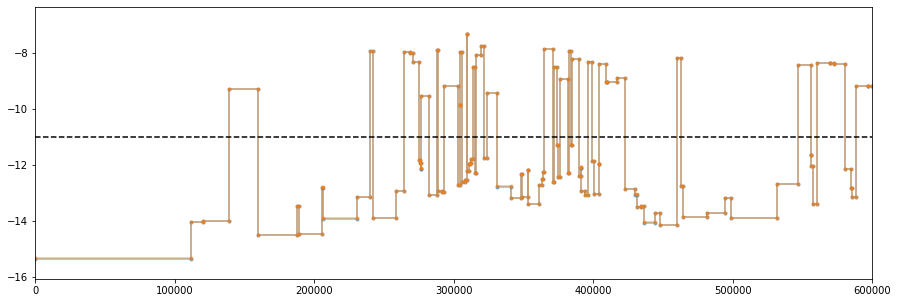

In [320]:
chrom = '20'
lamb = 10
k = 0
recomb_file = '../recombination_rate/chip_linked'

all_positions = []
with open('%s.positions.txt' % recomb_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        all_positions.append((pieces[0], int(pieces[1])))
lengths = np.load('%s.lengths.npy' % recomb_file)
        
ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
print(len(all_positions), lengths.shape, ps_mat.shape, ps_pat.shape)
print(all_positions[:5])

plt.figure(figsize=(15, 5))
indices = [c==chrom for c, p in all_positions[:-1]]
p = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_mat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
indices = [c==chrom for c, p in all_positions[:-1]]
q = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
plt.axhline(-11, color='black', linestyle='--')

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

plt.xlim([0, 600000])
plt.show()


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater


Maternal
genome in hotspot 0.12478295889584753
train crossovers in hotspot 0.9998381097696707
test crossovers in hotspot 0.8555073974506684


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in subtract


Paternal
genome in hotspot 0.12030589549257627
train crossovers in hotspot 0.9998435177216181
test crossovers in hotspot 0.8451974236908429


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in greater


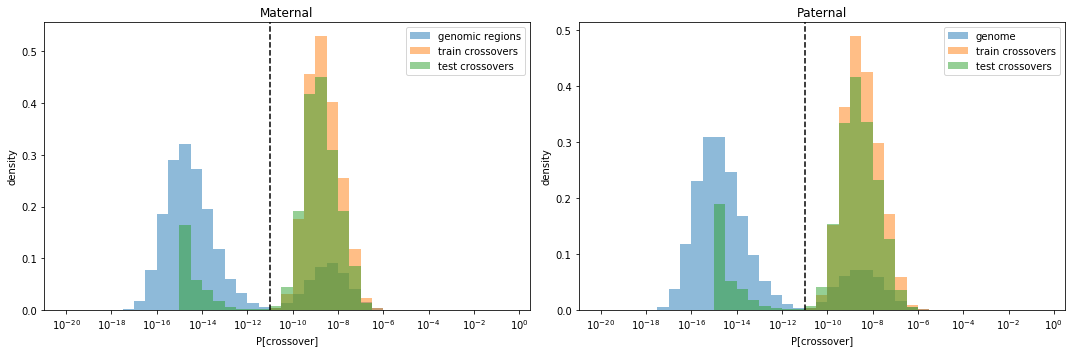

In [224]:
plt.figure(figsize=(15, 5))

bins = np.arange(-20, 0, 0.5)
k = 0
lamb = lambs[0]

plt.subplot(1, 2, 1)
#co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%.0f.%d.npy' % (recomb_file, lamb, k))

#X_mat_train = sparse.load_npz('%s.X_mat_train.%s.%d.npz' % (recomb_file, lamb, k))
#X_mat_test = sparse.load_npz('%s.X_mat_test.%s.%d.npz' % (recomb_file, lamb, k))

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genomic regions')
is_hotspot_mat = (ps_mat/lengths > cutoff)
    
co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

print('Maternal')
print('genome in hotspot', (ps_mat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_mat_train/co_lengths_mat_train > cutoff)/len(co_ps_mat_train))
print('test crossovers in hotspot', np.sum(co_ps_mat_test/co_lengths_mat_test > cutoff)/len(co_ps_mat_test))
    
plt.hist(np.clip(np.log10(co_ps_mat_train) - np.log10(co_lengths_mat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_mat_test) - np.log10(co_lengths_mat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
#co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%.0f.%d.npy' % (recomb_file, lamb, k))
    
#X_pat_train = sparse.load_npz('%s.X_pat_train.%s.%d.npz' % (recomb_file, lamb, k))
#X_pat_test = sparse.load_npz('%s.X_pat_test.%s.%d.npz' % (recomb_file, lamb, k))
    
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genome')

co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
 
print('Paternal')
print('genome in hotspot', (ps_pat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_pat_train/co_lengths_pat_train > cutoff)/len(co_ps_pat_train))
print('test crossovers in hotspot', np.sum(co_ps_pat_test/co_lengths_pat_test > cutoff)/len(co_ps_pat_test))

plt.hist(np.clip(np.log10(co_ps_pat_train) - np.log10(co_lengths_pat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_pat_test) - np.log10(co_lengths_pat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()